# Exploración del dataset


In [1]:
import pandas as pd
import rdflib
import numpy

In [2]:
df = pd.read_csv('dataset/raw.csv.gz', dialect='excel', keep_default_na=False, dtype=str, index_col=0)

El dataset tiene un indice que no se corresponde con la cantidad de filas del dataset, sino con el dataset original. Para acceder a las filas se puede usar `.loc[indice]` en lugar de `.iloc[indice]`.

In [11]:
df

,_validation,address,advertiser_id,advertiser_name,age,bath_amnt,bed_amnt,bed_ratio,covered_ratio,covered_surface,...,toilet_amnt,total_ratio,total_surface,total_surface_unit,transaction,uncovered_surface,uncovered_surface_unit,url,year_built,dup_candidates
0,,Silverio Almiro (32) 200,209733492,AMITRANO PROPIEDADES,,2,3,46666.666666666664,848.4848484848485,165,...,,215.3846153846154,650,m²,Venta,,,https://api.mercadolibre.com/items/MLA1397276203,,0
1,,Calle 30,209733492,AMITRANO PROPIEDADES,,4,4,,675.1054852320675,237,...,,146.5201465201465,1092,m²,Venta,,,https://api.mercadolibre.com/items/MLA1387444376,,1
2,,Calle 24 600,209733492,AMITRANO PROPIEDADES,,2,2,80000.0,1230.7692307692307,130,...,,133.33333333333334,1200,m²,Venta,,,https://api.mercadolibre.com/items/MLA1604232518,,2
3,,Zona Rural,209733492,AMITRANO PROPIEDADES,,5,5,,34000.0,5,...,,34000.0,5,m²,Venta,,,https://api.mercadolibre.com/items/MLA1397251953,,3
4,,"San Juan & Ruta Nacional 8, Viña, Provincia de...",63383570,,,,,,,,...,,44.082840236686394,338,m²,Venta,,,https://api.mercadolibre.com/items/MLA1402431467,,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764986,,,185660,,0,1,1,38000.0,1000.0,38.0,...,,950.0,40.0,m²,Venta,,,https://www.argenprop.com/casa-en-venta-en-azu...,2024,10661 223694 764986
764987,,,218460,,,,,,,,...,,43.71584699453552,366.0,m²,Venta,,,https://www.argenprop.com/terreno-en-venta-en-...,,10668 10669 223632 223697 764987 764988
764988,,,218460,,,,,,,,...,,43.24324324324324,370.0,m²,Venta,,,https://www.argenprop.com/terreno-en-venta-en-...,,10668 10669 223632 223697 764987 764988
764991,,,185660,,,,,,,,...,,27.77777777777778,234.0,m²,Venta,,,https://www.argenprop.com/terreno-en-venta-en-...,,29417 237004 764991


In [ ]:
df.loc[764981]  # .loc hace referencia al indice

In [ ]:
df.iloc[764981] # .iloc hace referencia al número de fila dentro del dataset

In [13]:
df[['address', 'description', 'dup_candidates']]

,address,description,dup_candidates
0,Silverio Almiro (32) 200,"Chalet s/lote de 13 x 50 metros, consta de liv...",0
1,Calle 30,"Excelente propiedad sobre 2 lotes de 9,60 x 60...",1
2,Calle 24 600,"Casa sobre lote de 24 x 50, posee living comed...",2
3,Zona Rural,"Chaca de 55.137 m² en zona rural de Ameghino, ...",3
4,"San Juan & Ruta Nacional 8, Viña, Provincia de...","El frente de cada terreno es de 13 m, con sali...",4
...,...,...,...
764986,,_ Departamento de un dormitorio en venta ubica...,10661 223694 764986
764987,,El equipo RE/MAX SEIRRAS vende amplio lote ubi...,10668 10669 223632 223697 764987 764988
764988,,El equipo RE/MAX SIERRAS vende lotes ubicados ...,10668 10669 223632 223697 764987 764988
764991,,_ Terreno de 234mts2 en venta ubicado en calle...,29417 237004 764991


Obtener mis las lineas en las que tengo que trabajar.

In [4]:
df.iloc[1200:1400]

,_validation,address,advertiser_id,advertiser_name,age,bath_amnt,bed_amnt,bed_ratio,covered_ratio,covered_surface,...,toilet_amnt,total_ratio,total_surface,total_surface_unit,transaction,uncovered_surface,uncovered_surface_unit,url,year_built,dup_candidates
1200,,"Marconi 573 - ""6to"" - Piso de 3 Ambientes",1125040570,CHV,0,1,2,60000.0,1643.835616438356,73,...,,1411.764705882353,85,m²,Venta,,,https://api.mercadolibre.com/items/MLA1501261312,,990 1200
1201,,comodoro rivadavia 4631. Entre Posadas y Pierres,416660838,Alvarez Propiedades,20.0,2,3,76666.66666666667,1437.5,160,...,,877.8625954198474,262,m²,Venta,,,https://api.mercadolibre.com/items/MLA1401334001,2004,1201 611887
1202,,San Nicolas al 5600,51495211,ADRIAN MERCADO REAL ESTATE DIVISION OFICINAS...,30.0,2,4,57500.0,821.4285714285714,280,...,,821.4285714285714,280,m²,Venta,,,https://api.mercadolibre.com/items/MLA1401273091,1994,1202 380979 611913
1203,,Maestro Ángel D'elía 400,30045743,PESCIO INMOBILIARIA,0,1,1,80000.0,1600.0,50.0,...,,1481.4814814814815,54.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
1204,,San José al 100,17913362,ESTRADA - Inversiones Inmobiliarias,0,,,,,,...,,339.1959798994975,398.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1107 1204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,,Peron 500,30021799,Coseglia Propiedades,,,1,78000.0,2166.6666666666665,36.0,...,,9750.0,8.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,,1395 5365 349224 648478
1396,,Paula Albarracin 1400. Entre Hercules binda,30022714,H. Granelli Propiedades,,2,4,21250.0,714.2857142857143,119.0,...,,354.1666666666667,240.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,,1396
1397,,Serrano,30022465,Constructora J.Jireh S.A,0,1,1,75000.0,1875.0,40.0,...,,1785.7142857142858,42.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1397
1398,,Sargento Cabral 1335. Entre Domingo faustino s...,17944894,Federico Negro Estudio Inmobiliario,,1,1,53000.0,1394.7368421052631,38.0,...,,1394.7368421052631,38.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,,1398


☝️ Chequear que tenga 200 filas

Obtener los candidatos duplicados para una fila

In [23]:
df['nrofila'] = range(len(df))

In [38]:
df.loc[[199,305206]].dup_candidates

199       199 305206 624765
305206    199 305206 624765
Name: dup_candidates, dtype: object

In [35]:
# list comprehensions
'199 305206 624765'.split(' ')

['199', '305206', '624765']

In [36]:
[int(x) for x in '199 305206 624765'.split(' ')]

[199, 305206, 624765]

In [37]:
ln = []
for x in df.loc[1203]:
    ln.append(int(x))
ln

[199, 305206, 624765]

Chequear las descripciones de una fila

In [9]:
candidates = [int(x) for x in df.iloc[1203].dup_candidates.split()] # Esto devuelve una lista de indices [990, 1200]
df.loc[candidates] # Esto devuelve las filas de un dataset en esa lista de indices

,_validation,address,advertiser_id,advertiser_name,age,bath_amnt,bed_amnt,bed_ratio,covered_ratio,covered_surface,...,toilet_amnt,total_ratio,total_surface,total_surface_unit,transaction,uncovered_surface,uncovered_surface_unit,url,year_built,dup_candidates
1203,,Maestro Ángel D'elía 400,30045743,PESCIO INMOBILIARIA,0,1,1,80000.0,1600.0,50.0,...,,1481.4814814814815,54.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
1726,,Maestro Ángel D'elía 400,30045743,PESCIO INMOBILIARIA,0,1,1,80000.0,1481.4814814814815,54.0,...,,1379.3103448275863,58.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
4220,,Maestro Ángel D'elia al 400,30045743,PESCIO INMOBILIARIA,0,1,1,75000.0,1388.888888888889,54.0,...,,1293.103448275862,58.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
5644,,Maestro Angel D'elia al 400,30045743,PESCIO INMOBILIARIA,0,1,1,75000.0,1388.888888888889,54.0,...,,1293.103448275862,58.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
11891,,Maestro Angel D'elia al 400,30045743,PESCIO INMOBILIARIA,0,1,1,70000.0,1400.0,50.0,...,,1228.0701754385964,57.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
11907,,Maestro Angel D'elia al 400,30045743,PESCIO INMOBILIARIA,0,1,1,70000.0,1400.0,50.0,...,,1228.0701754385964,57.0,m²,Venta,,,https://www.zonaprop.com.ar/propiedades/clasif...,2024,1203 1726 4220 5644 11891 11907 350078 350128 ...
350078,,Maestro Angel D'elia al 400,363665584,Pescio Inmobiliaria,0,1,1,75000.0,1388.888888888889,54,...,,1293.103448275862,58,m²,Venta,,,https://api.mercadolibre.com/items/MLA1401291489,,1203 1726 4220 5644 11891 11907 350078 350128 ...
350128,,Maestro Angel D'elia al 400,363665584,Pescio Inmobiliaria,0,1,1,70000.0,1400.0,50,...,,1228.0701754385964,57,m²,Venta,,,https://api.mercadolibre.com/items/MLA1619563922,,1203 1726 4220 5644 11891 11907 350078 350128 ...
350337,,Maestro Ángel D'elia al 400,363665584,Pescio Inmobiliaria,0,1,1,75000.0,1388.888888888889,54,...,,1293.103448275862,58,m²,Venta,,,https://api.mercadolibre.com/items/MLA1401214187,,1203 1726 4220 5644 11891 11907 350078 350128 ...
626453,,,251605,,,1,,,1500.0,30.0,...,,1216.2162162162163,,,Venta,7.0,m²,https://www.argenprop.com/departamento-en-vent...,,1409 1880 3615 324960 626453 627877 627879 650...


In [10]:
# muestra las descripciones de cada aviso junto con sus indidces...
for idx, desc in zip(candidates,df.loc[candidates]['description']):
    print(f' {idx}   ******************')
    print(desc)
    print()

 1203   ******************
 Llega DOM D´Elía, un emprendimiento residencial único, con un concepto arquitectónico moderno, innovador y de calidad constructiva. Utilizando materiales nobles como el hormigón, vidrio y metal, diseñado para vivir con las comodidades de una casa, priorizando el confort interior y exterior. Departamentos con balcón aterrazado, ideales para disfrutar la naturaleza y los momentos de relax. -Ubicación privilegiada, a metros de la estación Muñiz del ferrocarril San Martin, cercano al centro comercial, oferta gastronómica, hipermercado, escuelas, zonas recreativas, deportivas y a 50´ de C.A.B.A. - Planta baja de cocheras. - 6 niveles con departamentos de 1 I 2 I 3 Ambientes. - Top Amenities: Parrillas en azotea, gran solárium con duchas, espacio multieventos y guarda bicis. ¡No te pierdas esta gran oportunidad de inversión y viví como realmente querés! Desde USD con cochera descubierta Precio de Lista. Entrega estimada: 12 MESES. ANTICIPO DEL 30 % EL SALDO A PAGA

## El curado de los datos
Lo que debemos hacer es revisar los avisos a ver si los candidatos realmente están duplicados o no. -+En caso de no estar duplicados, la columna dup_candidates debe ser corregida. Suponga que estamos revisando la fila 199. El valor de la columna `dup_candidates` para la fila 199 es `'199 305206 624765'`, es decir que las filas 305206 y 624765 son duplicadas de la 199. No es el caso en este ejemplo, pero supongamos que la fila 305206 no hace referencia a la misma propiedad. Entonces, la versión corregida para `dup_candidates` debería contener solo `'199 624765'`. Por el contrario, si efectivamente todas las ocurrencias hablan de la misma propiedad, entonces la versión corregida para `dup_candidates` debería quedar exactamente igual, es decir `'199 305206 624765'`.

La idea es generar una nueva lista de 200 strings, con las columnas revisadas y agregarla a un nuevo dataset.

In [52]:
# Inserte su metodología para detectar duplicados aquí!
# El resultado debe ser una lista de 200 strings.

revised = ['']*200
revised[0] = '200'
revised[1] = ''
revised[2] = ''
# ...
revised[199] = ''; # <=== Cuidado con el orden de la lista!
revised[-10:] 

['', '', '', '', '', '', '', '', '', '']

La nueva lista de strings puede tener valores en blanco (un string vacio `''`). Esto indica que esa fila no fue revisada. Además, el orden de los indices no importa, por lo tanto `'199 305206 624765'` es igual a `'199 624765 305206'` y a `'305206 624765 199'`. 

## Forma del entregable
El entregable será un nuevo dataset con una nueva columna llamada `dup_curated` el cual contrendrá un string nuevo por cada fila. Este string representará las filas que están duplicadas que han sido verificadas. Si las filas con indice 199, 305206 y 624765 están efectivamente duplicadas, como en el ejemplo anterior, la nueva columna debe quedar igual, es decir, para la fila con indice 199 tendrá el valor

`199 305206 624765`

Una vez que estemos contentos con la nueva lista revisada, vamos a crear un nuevo dataset y a agregar la nueva columna. Si el dataset no tiene la misma longitud que la lista, nos va a dar error! Ojo con eso y ojo con el orden de los elementos de la lista. 

In [53]:
newdf = df.iloc[200:400][['dup_candidates']]
newdf

,dup_candidates
200,200
201,207 191 192 196 201 206 227922 227939 229244 2...
202,202 612306
203,203 180497 180511
204,204 612305
...,...
395,395 345302 631347
396,396
397,397
398,398


In [54]:
newdf['dup_curated'] = revised

In [55]:
newdf

,dup_candidates,dup_curated
200,200,200
201,207 191 192 196 201 206 227922 227939 229244 2...,
202,202 612306,
203,203 180497 180511,
204,204 612305,
...,...,...
395,395 345302 631347,
396,396,
397,397,
398,398,


In [56]:
grupo_nro = 2
newdf.to_csv(f'dataset/entrega_tis_grupo_{grupo_nro:02}.csv.gz', escapechar='"')

In [12]:
df.price

0         140000
1         160000
2         160000
3         170000
4          14900
           ...  
764986     38000
764987     16000
764988     16000
764991      6500
764992      6500
Name: price, Length: 55227, dtype: object

In [13]:
df.price.astype(int)

ValueError: invalid literal for int() with base 10: 'nan'

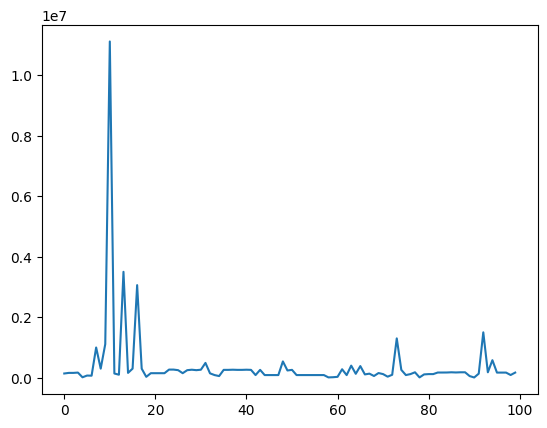

In [23]:
import matplotlib
matplotlib.pyplot.plot(df.price.iloc[:100].astype(int))